# Motive / Optitrack to OpenEphys alignment
Assumes a TTL from Motive to OpenEphys at the start of each recording. If it doesn't find that, will try to align by timestamps.

IMPORTANT NOTE: Watch out for any warnings about start time having "second precision" when creating the `sync_df` DataFrame below, this will percolate through to all synchronized devices.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
from pathlib import Path

sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy/'])  # Add path to NeuroPy repository here
sys.path.extend(['/data/GitHub/NeuroPy/'])

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.optitrackio import OptitrackIO
import neuropy.io.openephysio as oeio
from neuropy.core.epoch import Epoch

## Load in session data and Open Ephys timestamps

In [2]:
dir_use = Path("/data3/Psilocybin/Recording_Rats/Finn/2022_02_17_psilocybin")
sess = core.ProcessData(dir_use)

# Create sync_df to ID start and end of each recording in concatenated .eeg file
sync_df = oeio.create_sync_df(dir_use)

# Get absolute time from start of first recording
sync_df['Tabs from start (s)'] = (sync_df['Datetime'] - sync_df['Datetime'].iloc[0]).dt.total_seconds()
sync_df

start time = 2022-02-17 10:33:51.810584-05:00
start time = 2022-02-17 10:45:04.949076-05:00
start time = 2022-02-17 11:44:40.100407-05:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time,Tabs from start (s)
0,0,2022-02-17 10:33:51.810584-05:00,start,0,0.000000,0,0.0000,0.000000
1,0,2022-02-17 10:39:00.589217333-05:00,stop,9263359,308.778633,385973,308.7784,308.778633
2,1,2022-02-17 10:45:04.949076-05:00,start,9263360,308.778667,385974,308.7792,673.138492
3,1,2022-02-17 11:43:54.805042667-05:00,stop,115159039,3838.634633,4798293,3838.6344,4202.994459
4,2,2022-02-17 11:44:40.100407-05:00,start,115159040,3838.634667,4798294,3838.6352,4248.289823
5,2,2022-02-17 13:24:56.424640333-05:00,stop,295648767,9854.958900,12318698,9854.9584,10264.614056


## Next get OptiTrack recording start

### Method 1: Calculate from .tak file modification time and # frames in .avi file(no rigid body tracking or .csv file, ~millisecond precision?).

This method is used for synchronizing below...

In [3]:
from datetime import datetime
from neuropy.io.dlcio import DLC
import os

tak_file_dir = Path("/run/media/nkinsky/LWD_Backup/Nat/Psilocybin/Recording_Rats/Finn/2022_02_17_psilocybin/")
dlc_file_dir = Path("/data3/Psilocybin/Recording_Rats/Finn/2022_02_17_psilocybin/")

if not (sess.basepath / "inferred_start_time.csv").exists():

    tak_files = sorted(tak_file_dir.glob("**/*.tak"))
    
    mtimes = []
    for tak_file in tak_files:
        mtimes.append(pd.Timestamp(datetime.fromtimestamp(os.path.getmtime(tak_file))))
    
    dlc = DLC(dlc_file_dir, movie_type=".avi")
    
    opti_sr = dlc.SampleRate
    mtimes
else:
    print("inferred_start_time.csv file already exists. Load in below")

inferred_start_time.csv file already exists. Load in below


In [4]:
from neuropy.io.movie import tracking_movie

tz = "America/Detroit"
if (sess.basepath / "inferred_start_time.csv").exists():
    print("inferred_start_time.csv file already exists. Load in below")
else:
    start_times, nframes, samplerate = [], [], []
    for tak_file, mtime in zip(tak_files, mtimes):
        try:
            movie_file = sorted(tak_file.parent.glob(f"{tak_file.stem}*.avi"))[0]
            mobj = tracking_movie(str(movie_file))
            start_times.append((mtime - pd.Timedelta(mobj.nframes / dlc.SampleRate, unit="sec")).tz_localize(tz))
            nframes.append(mobj.nframes)
            samplerate.append(mobj.SampleRate)
        except IndexError:
            start_times.append(np.nan)
            nframes.append(np.nan)
            samplerate.append(np.nan)
    
    start_times

inferred_start_time.csv file already exists. Load in below


In [5]:
if not (sess.basepath / "inferred_start_time.csv").exists():
    start_time_df = pd.DataFrame({"file": [tak_file.stem for tak_file in tak_files], 
                                  "mod_time": mtimes,
                                  "inferred_start_time": start_times,
                                  "nframes": nframes,
                                  "SampleRate": samplerate,
                                  "Opti_Recording": np.arange(len(tak_files))})
    
    start_time_df.to_csv(sess.basepath / "inferred_start_time.csv")
else:
    print("Adding in fields and converting to timestamps")
    start_time_df = pd.read_csv(sess.basepath / "inferred_start_time.csv", index_col=0, parse_dates=["mod_time", "inferred_start_time"])
    start_time_df = start_time_df.sort_values(by="mod_time", ignore_index=True)
    try:
        start_time_df["mod_time"] = pd.to_datetime(start_time_df["mod_time"]).dt.tz_localize(tz)
    except TypeError:
        pass
    try:
        start_time_df["inferred_start_time"] = pd.to_datetime(start_time_df["inferred_start_time"]).dt.tz_localize(tz)
    except TypeError:
        pass
start_time_df

Adding in fields and converting to timestamps


,file,mod_time,inferred_start_time,nframes,SampleRate,Opti_Recording
0,Take 2022-02-17 10.33.54 AM,2022-02-17 10:39:03.033000-05:00,2022-02-17 10:33:54.599666667-05:00,9253.0,30.0,0
1,Take 2022-02-17 10.45.11 AM,2022-02-17 13:24:52.349000-05:00,2022-02-17 10:45:12.649000-05:00,287391.0,30.0,1


In [6]:
# Add in nframes and SampleRate if missing from start_time_df and re-save
movie_dir = dlc_file_dir
if "nframes" not in start_time_df.keys():
    nframes, samplerate = [], []
    for file_stem in start_time_df.file.values:
        try:
            movie_file = movie_dir / f"{file_stem}-Camera 4 (#410110).avi"
            mobj = tracking_movie(str(movie_file))
            # start_times.append((mtime - pd.Timedelta(mobj.nframes / dlc.SampleRate, unit="sec")).tz_localize(tz))
            nframes.append(mobj.nframes)
            samplerate.append(mobj.SampleRate)
        except IndexError:
            start_times.append(np.nan)
            nframes.append(np.nan)
            samplerate.append(np.nan)
    start_time_df["nframes"] = nframes
    start_time_df["SampleRate"] = samplerate
    start_time_df["Opti_Recording"] = np.arange(start_time_df.shape[0])
    start_time_df.to_csv(sess.basepath / "inferred_start_time.csv")
else:
    print("nframes and SampleRate already in df")
start_time_df

nframes and SampleRate already in df


,file,mod_time,inferred_start_time,nframes,SampleRate,Opti_Recording
0,Take 2022-02-17 10.33.54 AM,2022-02-17 10:39:03.033000-05:00,2022-02-17 10:33:54.599666667-05:00,9253.0,30.0,0
1,Take 2022-02-17 10.45.11 AM,2022-02-17 13:24:52.349000-05:00,2022-02-17 10:45:12.649000-05:00,287391.0,30.0,1


### Method 2: From .csv file output from .tak file (microsecond precision)
Note that lag from start time logged in .tak file to actual recording start time can be ~1.5 seconds.  

Not used below.

In [ ]:
csv_path = "/data2/Alternation/Recording_Rats/Finn/2022_02_01_alternation2/1_alternation/"
opti = OptitrackIO(csv_path)
tstart_from_csv = opti.datetime_array[0]
tstart_from_csv

## Method 1: Motive start triggers some TTLs (but not all) at start only.
Example: Motive start triggers miniscope data acquisition which delivers a TTL for each frame acquired. Therefore the start of a TTL block can coincide with a Motive recording start, but in case of a disconnect we may a miniscope recording restart without restarting Motive.

In [7]:
# Load in ALL TTLs
ttl_start_chan_use = 1
ttl_df = oeio.load_all_ttl_events(dir_use)
ttl_df = ttl_df[ttl_df.channel_states.abs() == ttl_start_chan_use]
ttl_df

,channel_states,timestamps,datetimes,sample_number,event_name,Recording
0,-1,82316,2022-02-17 10:33:54.554450667-05:00,82316,,0
1,1,84406,2022-02-17 10:33:54.624117333-05:00,84406,,0
2,-1,86359,2022-02-17 10:33:54.689217333-05:00,86359,,0
3,1,88384,2022-02-17 10:33:54.756717333-05:00,88384,,0
4,-1,90431,2022-02-17 10:33:54.824950667-05:00,90431,,0
...,...,...,...,...,...,...
87446,1,180048639,2022-02-17 13:24:41.721707-05:00,295207679,,2
87447,-1,180050692,2022-02-17 13:24:41.790140333-05:00,295209732,,2
87448,1,180052682,2022-02-17 13:24:41.856473667-05:00,295211722,,2
87449,-1,180054703,2022-02-17 13:24:41.923840333-05:00,295213743,,2


In [8]:
# Workhorse code to align each motive recording to each corresponding block of TTLs in OE.
# Start times of each OptiTrack recording in combined eeg time are accurate, but we will need to re-align any
# portions of Optitrack recordings that bridge two or more OE recording below.

buffer_sec = 1 # time buffer in seconds for start / stop detection
oe_sr = 30000  # OpenEphys sample rate
buffer_td = pd.Timedelta(buffer_sec, unit="sec")

opti_times_df = []
for idr, row in start_time_df.iterrows():
    
    # First grab timestamp for Optitrack/Motive recording start
    opti_start = row["inferred_start_time"]
    
    # Next ID ephys recording start based on closest TTL to start
    rec_bool = ((sync_df[sync_df.Condition == "start"]["Datetime"] - buffer_td)  < opti_start).values & ((sync_df[sync_df.Condition == "stop"]["Datetime"] + buffer_td) > opti_start).values
    rec_df = sync_df[sync_df.Condition == "start"][rec_bool]
    if rec_df.shape[0] == 0:  # Skip this recording if there is no time data (e.g. if corrupted)
        continue
    else:
            
        oe_rec_num_use = rec_df["Recording"].iloc[0]
        oe_rec_num_use
        
        # Grab ttls from specific recording
        ttl_rec = ttl_df[ttl_df.Recording == oe_rec_num_use]
        
        oe_start_inds = np.where((ttl_rec["timestamps"].diff() > (buffer_sec * oe_sr)) |  np.isnan(ttl_rec["timestamps"].diff()))[0]
        start_ind = oe_start_inds[np.where((ttl_rec.iloc[oe_start_inds]["datetimes"] - opti_start).dt.total_seconds().abs() < buffer_sec)[0]]
        if len(start_ind) < 1:  # Align all timestamps roughly to start of oe recordings
    
            # Note that these frames don't have a starting TTL so there is second precision
            start_delta = pd.Timedelta(0)
            starting_ttl = False
            precision = "s"
        else:
        
        # assert len(start_ind) == 1, "multiple candidate start times found in OE TTLs, adjust buffers and try again"
            start_ttl = ttl_rec.iloc[start_ind[0]]
            
            # Print stuff to screen as sanity check
            # print(f"MS start = {ms_start_ts}")
            # print(f"Corresponding TTL time in OE = {start_ttl['datetimes']}")
        
            # Calculate delta between miniscope time start and ttl received in OE
            start_delta = start_ttl['datetimes'] - opti_start
            start_ttl = True
            precision = "TTL"
            # print(f"start_delta_sec={start_delta.total_seconds()}")
        
        # Now adjust each timestamp in miniscope timestamps by start offset from OE TTL 
        prior_oe_rec_start_dt = sync_df[(sync_df.Recording == oe_rec_num_use) & (sync_df.Condition == "start")].iloc[0]["Datetime"]
        prior_oe_rec_start_comb_time = sync_df[(sync_df.Recording == oe_rec_num_use) & (sync_df.Condition == "start")].iloc[0]["eeg_time"]
        opti_ts = pd.Series(row["inferred_start_time"] +  pd.to_timedelta(np.arange(row["nframes"])/row["SampleRate"], unit='s'))
        opti_times_eeg_align = pd.DataFrame({"Timestamps":(opti_ts + start_delta - prior_oe_rec_start_dt).dt.total_seconds() + prior_oe_rec_start_comb_time,
                                            "Start_TTL": start_ttl,
                                            "Precision": precision})
        
        # Save recording number
        opti_times_eeg_align["Opti_Recording"] = row["Opti_Recording"]
        
        opti_times_df.append(opti_times_eeg_align)

# Get output times of all miniscope timestamps now referenced to the concatenated eeg time.
opti_ts_align_df = pd.concat(opti_times_df, axis=0)
opti_ts_align_df

,Timestamps,Opti_Recording
0,2.743867,0
1,2.777200,0
2,2.810533,0
3,2.843867,0
4,2.877200,0
...,...,...
287386,9896.035967,1
287387,9896.069300,1
287388,9896.102633,1
287389,9896.135967,1


### Fix any Motive times that extend across two recordings

In [9]:
from copy import deepcopy
opti_ts_realign_df = []
for opti_rec in opti_ts_align_df["Opti_Recording"].unique():

    # Get Optitrack times for nth recoding 
    opti_times_eeg_realign = opti_ts_align_df[opti_ts_align_df["Opti_Recording"] == opti_rec]
    
    # Get optitrack start in absolute time from eeg start after aligning to concatenate eeg time
    opti_start_abs = np.interp(opti_times_eeg_realign["Timestamps"].loc[0], 
                               sync_df["eeg_time"], sync_df["Tabs from start (s)"])
    
    # Calculate delta to add to all timestamps in optitrack to get absolute time since OE recording start 
    opti_abs_delta = opti_start_abs - opti_times_eeg_realign["Timestamps"].loc[0]

    # Convert all Optritrack times to absolute time from EEG start
    opti_abs_times = opti_times_eeg_realign["Timestamps"] + opti_abs_delta
    opti_times_eeg_realign["Tabs_from_eeg_start"] = opti_abs_times

    # Identify OE recording for each absolute timestamp
    tabs_oe_starts = sync_df[sync_df.Condition == "start"]["Tabs from start (s)"]
    tabs_oe_stops = sync_df[sync_df.Condition == "stop"]["Tabs from start (s)"]

    oe_rec_by_start = np.digitize(opti_abs_times, tabs_oe_starts) - 1
    oe_rec_by_stop = np.digitize(opti_abs_times, tabs_oe_stops)

    # Loop through times corresponding to each OE recording and re-align to concatenate EEG
    for oe_rec in np.unique(np.hstack((oe_rec_by_start, oe_rec_by_stop))):
        
         # Tag optitrack frames by their corresponding OE recording
        oe_rec_bool = (oe_rec_by_start == oe_rec) & (oe_rec_by_stop == oe_rec) 
        opti_times_eeg_realign.loc[oe_rec_bool, "OE_Recording"] = oe_rec
    
        # Interpolate Optitrack timestamps to concatenated EEG for each OpenEphys recording
        opti_interp = np.interp(opti_abs_times[oe_rec_bool], sync_df["Tabs from start (s)"], sync_df["eeg_time"])
        opti_times_eeg_realign.loc[oe_rec_bool, "Timestamps_realigned"] = opti_interp
    
    opti_ts_realign_df.append(opti_times_eeg_realign)

opti_ts_realign_df = pd.concat(opti_ts_realign_df, axis=0).drop(columns="Timestamps")
opti_ts_realign_df

/tmp/ipykernel_795725/1809050160.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opti_times_eeg_realign["Tabs_from_eeg_start"] = opti_abs_times
/tmp/ipykernel_795725/1809050160.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opti_times_eeg_realign.loc[oe_rec_bool, "OE_Recording"] = oe_rec
/tmp/ipykernel_795725/1809050160.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

,Opti_Recording,Tabs_from_eeg_start,OE_Recording,Timestamps_realigned
0,0,2.743869,0.0,2.743867
1,0,2.777202,0.0,2.777200
2,0,2.810535,0.0,2.810533
3,0,2.843869,0.0,2.843867
4,0,2.877202,0.0,2.877200
...,...,...,...,...
287386,1,10260.395260,2.0,9850.739605
287387,1,10260.428594,2.0,9850.772938
287388,1,10260.461927,2.0,9850.806271
287389,1,10260.495260,2.0,9850.839605


### Sanity check plots

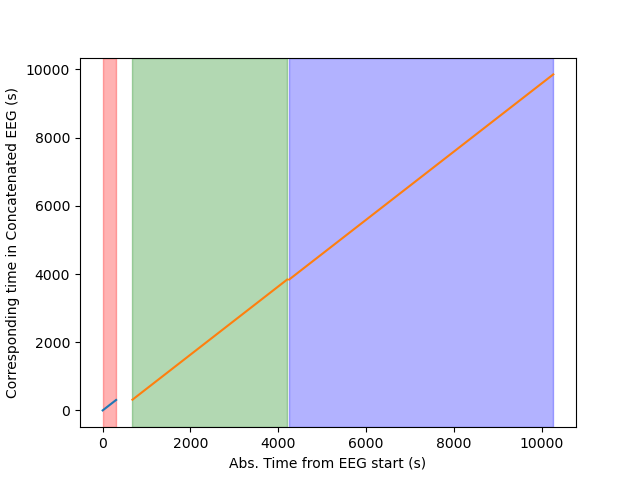

In [10]:
%matplotlib widget
# Plot concatenate EEG timestamps vs absolute time from experiment start with each OE recording overlaid in different colors
_, ax = plt.subplots()
for opti_rec in opti_ts_realign_df.Opti_Recording.unique():
    rec_df = opti_ts_realign_df[opti_ts_realign_df.Opti_Recording == opti_rec]
    ax.plot(rec_df["Tabs_from_eeg_start"], rec_df["Timestamps_realigned"])
ax.set_xlabel("Abs. Time from EEG start (s)")
ax.set_ylabel("Corresponding time in Concatenated EEG (s)")

colors = ['r', 'g', 'b', 'c']*4
for oe_rec in sync_df.Recording.unique():
    oe_rec_df = sync_df[sync_df.Recording == oe_rec]
    oe_start, oe_stop = oe_rec_df["Tabs from start (s)"].values
    ax.axvspan(oe_start, oe_stop, alpha=0.3, color=colors[int(oe_rec)])


### If above looks ok, then adjust dataframe and save.

Horizontal gaps should occur if you have an optitrack recording that spans two OE recordings, e.g. if OE had a disconnect but Motive ran throughout.

Diagonal gaps should occur if you started and stopped both Motive and OE in the same period.

In [68]:
opti_ts_realign_df = opti_ts_realign_df.rename(columns={"Timestamps": "abs_time_from_eeg_start", 
                                                        "Timestamps_realigned": "eeg_aligned_times"})
opti_ts_realign_df.to_csv(sess.filePrefix.with_suffix(".opti_times_aligned.csv"))
np.save(sess.filePrefix.with_suffix(".opti_times_aligned.npy"), opti_ts_realign_df, allow_pickle=True)

# Save this notebook to working directory after you are done for reference

In [11]:
import ipynbname
import shutil
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

nb_copy_savename = sess.filePrefix.with_suffix(".motive_align.ipynb")
shutil.copy(str(nb_path), str(nb_copy_savename))

'/data3/Psilocybin/Recording_Rats/Finn/2022_02_17_psilocybin/Finn_psilocybin_denoised.motive_align.ipynb'